In [128]:
from beakerx.object import beakerx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [129]:
df = pd.read_csv("Data/mnist_train.csv")
y = df.label
x = df.drop("label", axis=1)
x = x.values.reshape(60000,28,28)


In [130]:
def scale(X, x_min=0, x_max=1):
    nom = (X-X.min())*(x_max-x_min)
    denom = X.max() - X.min()
    denom = denom + (denom is 0)
    return x_min + nom/denom

In [131]:
x = scale(x)

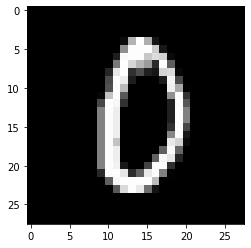

In [132]:
test_pic = x[random.randint(0,len(x))]
plt.imshow(test_pic, cmap="gray")

In [139]:
w_1 = np.random.randn(784,16)

In [140]:
w_1.shape

(784, 16)

In [141]:
l_1 = np.maximum(np.dot(test_pic.reshape(784), w_1), 0)

In [207]:
l_1

array([ 2.3401068 ,  0.        ,  7.31046558,  0.        ,  0.        ,
        0.        ,  0.        , 14.98906487,  0.        ,  0.        ,
       11.31109991,  9.12766312,  0.        ,  1.92535992,  5.69034325,
        3.8119601 ])

In [142]:
w_2 = np.random.randn(16,16)

In [143]:
l_2 = np.maximum(np.dot(l_1, w_2), 0)

In [144]:
w_3 = np.random.randn(16,10)

In [145]:
def softmax(inp):
    return (np.e ** inp) / (sum(np.e ** inp))

In [146]:
output = softmax(np.dot(l_2,w_3))

In [147]:
output

array([6.30699153e-01, 2.40279195e-02, 7.61763694e-10, 4.44447594e-21,
       1.15865581e-27, 1.20582459e-11, 1.36891914e-35, 3.45272926e-01,
       1.45499741e-28, 2.39092756e-32])

In [ ]:
784,[16,16,10]

(784,16)
(16,16)
(16,10)

In [289]:
class Dense:
    def __init__(self, layers, img_rows, img_cols):
        self.img_size = img_rows * img_cols
        self.num_layers = len(layers)
        self.layers = layers
        self.biases = [np.random.randn(y) for y in layers]
        self.weights = [np.random.randn(self.img_size,layers[0])]
        for i in range(self.num_layers-1):
            self.weights.append(np.random.randn(layers[i], layers[i+1]))


    def forward(self, inp):
        for b,w in zip(self.biases, self.weights):
            inp = relu(np.dot(inp, w) + b)
        return inp





    def relu(inp):
        return np.maximum(inp,  0)


In [290]:
temp = Dense([16, 15, 14,16,10], 28, 28).forward(test_pic.reshape(784))

In [291]:
temp

array([  0.        ,   0.        , 867.1204252 ,   0.        ,
       525.67510204,   0.        ,   0.        ,   0.        ,
         0.        , 104.50077921])